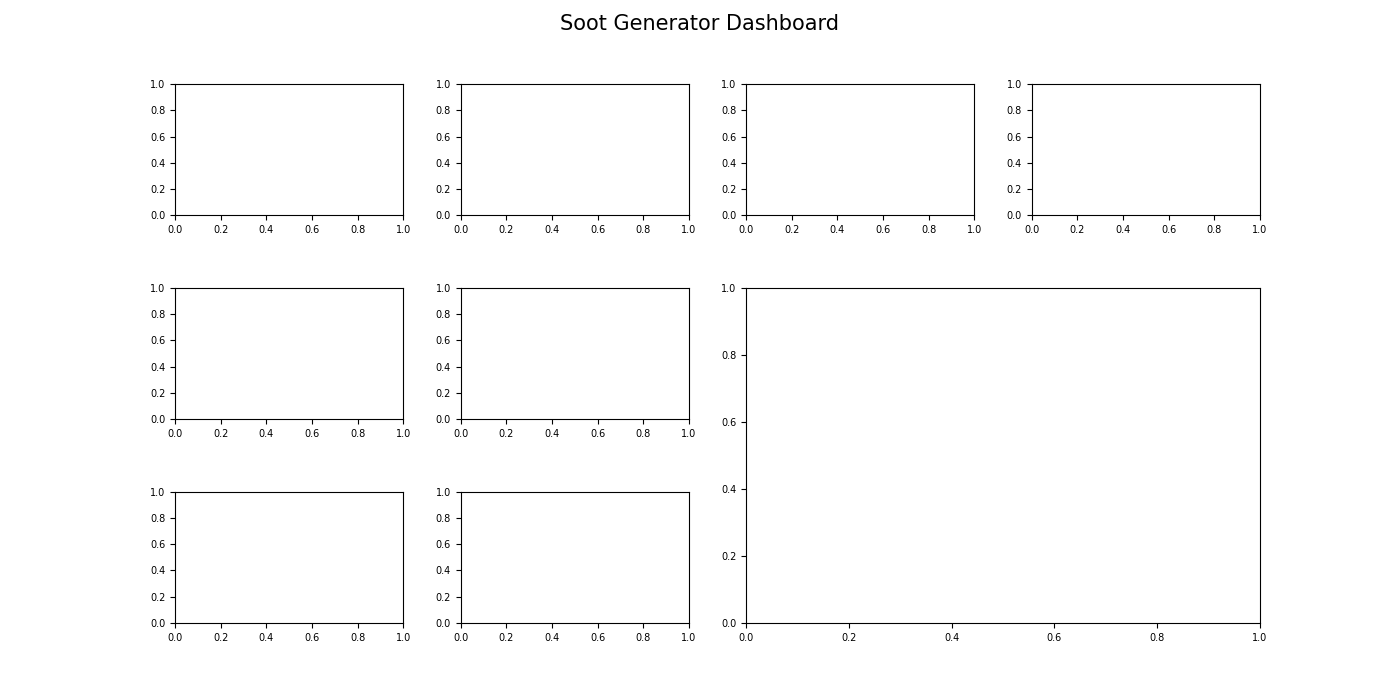

In [2]:
%matplotlib ipympl 
#matplotlib interactive for IPython

#import libraries and functions
import winsound # to make speaker beep
import glob # to get files by path
import pandas as pd
import math
import ipywidgets, asyncio, time
from datetime import datetime # for naming pulse/flush files
import matplotlib.pyplot as plt # to make mpl faster
import matplotlib as mpl # to make mpl faster
import numpy as np #numpy for tons of stuff
import matplotlib.style as mplstyle
mpl.rcParams['path.simplify_threshold'] = 1.0 # to make mpl faster
mplstyle.use('fast') # to make mpl faster
import AlicatMFC as alicat #main python file to use functions from there
import analysis
from scipy.signal import savgol_filter # savgol filter for smoothing

#styles to limit the description width
numberStyle = {'description_width': "33%"}
numberstyle2  = {'description_width': "40%"}
itemLayout = ipywidgets.Layout(width = "auto",height = "30px")

def colLayout(wid):
    return ipywidgets.Layout(display = "flex",flex_flow='column',border = '1px solid black',align_items = "stretch",justify_content="flex-start",width = wid)

#create widgets
running = ipywidgets.ToggleButton(description="start", icon="play",button_style = 'danger', layout = itemLayout) #whether program is running or not
propaneSetpoint = ipywidgets.FloatSlider(description = "Prop",value = 0, min = 0, max = 0.2, step = 0.005, layout = itemLayout)
airSetpoint = ipywidgets.FloatSlider(description = "Air",value = 0, min = 0, max = 10, step = 0.1, layout = itemLayout)
xlim = ipywidgets.IntSlider(description="xlim", value=1000, min=10, max=10000, step = 200, layout = itemLayout) #number of x values on matplotlib plots
ylim = ipywidgets.IntRangeSlider(description="ylim", value=[-20000,20000], min=-30000, max=100000, layout = itemLayout) #y range for matplotlib plots

timeBase = ipywidgets.FloatText(description = "Timebase", layout = itemLayout) #MA350 timebase
ewmNum = ipywidgets.IntText(description="EWM COM",value = 12, layout = itemLayout) #exponential mean weighting
tapePosition = ipywidgets.FloatText(description = "Tape Position", layout = itemLayout) #MA350
flowSetpoint = ipywidgets.FloatText(description = "Flow Setpoint", layout = itemLayout) #MA350
aethCOM = ipywidgets.Dropdown(description = "Bc COM",options = ['COM5','COM8'],value = "COM8",layout = itemLayout) #com port for the black carbon measurement
savePoints = ipywidgets.FloatText(description = "Save Num", value = 300, layout = itemLayout)  #number of points saved when saving pulse data

manualOverride = ipywidgets.Checkbox(value=True,description = "Manual Override", layout = itemLayout,indent = False) #manual override to control pulses
manualPulse = ipywidgets.Checkbox(value = False, description = "pulse? (time)", layout = itemLayout,indent = False) #click to pulse once
manualPulseTime = ipywidgets.FloatText(value = 0.5, step = 0.05,layout = ipywidgets.Layout(width ="50px" )) #time of manual pulse
manualPulseBox = ipywidgets.HBox(children = [manualPulseTime,manualPulse],layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto")) #horizontal box
pullingFlow = ipywidgets.FloatText(description = "pulling flow (mL/M)", layout = itemLayout, value = 1050) #the rate of flow out of the soot chamber (pump + measuring instruments)

flushSFCM = ipywidgets.FloatText(value = 0, layout = {'width':'50px'}) #if flushing with dilution air, measure at meniscus on rotameter in cubic feet per minute
flushing = ipywidgets.Checkbox(value = False, description = "flushing? (SFCM Dil)",layout = itemLayout,indent = False) #whether flushing or not
flushBox = ipywidgets.HBox(children = [flushSFCM,flushing],layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

plotTime = ipywidgets.Textarea(description="plot time", layout = itemLayout) #time to plot each matplotlib group
totalTime = ipywidgets.Textarea(description="run time", layout = itemLayout) #total time
elapsedTime = ipywidgets.Textarea(description="interval", layout = itemLayout) #elapsed time per main loop (should average 1.000 seconds)
interval = ipywidgets.FloatSlider(description="loop interval", value=1, min=0.001, max=3, layout = itemLayout) # zero can hang if you don't await
currentData = ipywidgets.Textarea(description="data", layout = itemLayout) #displays current data from MA350 or PAX
estimatedLag = ipywidgets.IntText(description = "estimated lag", layout = itemLayout, value = 20)

#bcc values
IRBc1 = ipywidgets.FloatText(description="IR Bc1", layout = itemLayout)
IRBcc = ipywidgets.FloatText(description="IR Bcc", layout = itemLayout)
Bc1EWM = ipywidgets.FloatText(description="ewm 1", layout = {'width':'45%'}, style = numberStyle)
BccEWM = ipywidgets.FloatText(description="ewm c", layout = {'width':'45%'}, style = numberStyle)
savgol1 = ipywidgets.FloatText(description="sav 1", layout = {'width':'45%'}, style = numberStyle)
savgolc = ipywidgets.FloatText(description="sav c", layout = {'width':'45%'}, style = numberStyle)
bc1 = ipywidgets.HBox(children = [Bc1EWM,savgol1], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))
bcc = ipywidgets.HBox(children = [BccEWM,savgolc], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

#checkboxes to show different elements of black carbon plot
showBcc = ipywidgets.Checkbox(value = True, description = "Bcc", layout = itemLayout,indent = False)
showEWM = ipywidgets.Checkbox(value = True, description = "EWM", layout = itemLayout,indent = False)
showSavgol = ipywidgets.Checkbox(value = False, description = "savgol", layout = itemLayout,indent = False)
killNoise = ipywidgets.Checkbox(value = False, description = "killnoise", layout = itemLayout,indent = False) #automatically lower air when flame starts to flicker by sensing noise
show = ipywidgets.HBox(children = [showBcc, showEWM,showSavgol,killNoise], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

completions = {"start":False,"one":False,"two":False,"three":False,"four":False}

#pulse x seconds every time the bcc goes below y threshold on average over z time period
startPulseDuration = ipywidgets.FloatText(description="start p", value = 1, layout = {'width':'30%'}, style = numberstyle2)
startPulseRest = ipywidgets.FloatText(description="start rest", value = 30, layout = {'width':'30%'}, style = numberstyle2)
startGoalConcentration = ipywidgets.IntText(description="start GC", value = 30000, layout = {'width':'30%'}, style = numberstyle2)
startRow = ipywidgets.HBox(children = [startPulseDuration, startPulseRest,startGoalConcentration], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

onePulseDuration = ipywidgets.FloatText(description="1 p", value = 1,layout = {'width':'30%'}, style = numberstyle2)
oneGoalConcentration = ipywidgets.IntText(description="1 GC", value = 30000,layout = {'width':'30%'}, style = numberstyle2)
onePulseRuns = ipywidgets.FloatText(description="1 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
oneRow = ipywidgets.HBox(children = [onePulseDuration, oneGoalConcentration,onePulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

twoPulseDuration = ipywidgets.FloatText(description="2 p", value = 1, layout = {'width':'30%'}, style = numberstyle2)
twoGoalConcentration = ipywidgets.IntText(description="2 GC", value = 15000,layout = {'width':'30%'}, style = numberstyle2)
twoPulseRuns = ipywidgets.FloatText(description="2 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
twoRow = ipywidgets.HBox(children = [twoPulseDuration, twoGoalConcentration,twoPulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

threePulseDuration = ipywidgets.FloatText(description="3 p", value = 0.5,layout = {'width':'30%'}, style = numberstyle2)
threeGoalConcentration = ipywidgets.IntText(description="3 GC", value = 10000,layout = {'width':'30%'}, style = numberstyle2)
threePulseRuns = ipywidgets.FloatText(description="3 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
threeRow = ipywidgets.HBox(children = [threePulseDuration, threeGoalConcentration,threePulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

fourPulseDuration = ipywidgets.FloatText(description="4 p", value = 1,layout = {'width':'30%'}, style = numberstyle2)
fourGoalConcentration = ipywidgets.IntText(description="4 GC", value = 40000,layout = {'width':'30%'}, style = numberstyle2)
fourPulseRuns = ipywidgets.FloatText(description="4 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
fourRow = ipywidgets.HBox(children = [fourPulseDuration, fourGoalConcentration,fourPulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

autoStatus = ipywidgets.Textarea(description ="status",layout = itemLayout,value = "nothing")
statusIndex = ipywidgets.IntText(value = 0)

zeroing = ipywidgets.Checkbox(value = False, description = "0ing", layout = itemLayout,indent = False)
pump = ipywidgets.Checkbox(value = False, description = "pump", layout = itemLayout,indent = False)
zeroPump = ipywidgets.HBox(children = [zeroing,pump], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))



#create widget layout
col1 = ipywidgets.VBox(children = [running,propaneSetpoint,airSetpoint,xlim,ylim],layout = colLayout("20%"))
col2 = ipywidgets.VBox(children = [timeBase,ewmNum,tapePosition,flowSetpoint,aethCOM],layout = colLayout("15%"))
col3 = ipywidgets.VBox(children = [manualOverride,manualPulseBox,flushBox,pullingFlow,zeroPump],layout = colLayout("15%"))
col4 = ipywidgets.VBox(children = [IRBc1,IRBcc,bc1,bcc,show],layout = colLayout("18%"))
col5 = ipywidgets.VBox(children = [plotTime,totalTime,elapsedTime,interval,currentData],layout = colLayout("20%"))
#automate things with col 6
col6 = ipywidgets.VBox(children = [startRow,oneRow,twoRow,threeRow,fourRow,autoStatus],layout = colLayout("30%"))
ui = ipywidgets.HBox([col1,col2,col3,col4,col5,col6],layout=ipywidgets.Layout(width = "1400px"))

#for managing asyncronous ts=asks
tasks = dict()

#create global panda dataframes
dfAeth =  pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm","humidity"])
dfMFC1 = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])       
dfMFC2 = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint']) 
dfSolenoid = pd.DataFrame(columns = ["timestamp","pulse duration","save status"]) #manages pulse data saving
dfFlush = pd.DataFrame(columns = ["timestamp","dilution flow","save status"]) #manages flush data saving

#dataframe for data to be saved
dfImportant = pd.DataFrame(columns = ["timestamp", "runtime","air pressure","air temperature","propane pressure", "propane temperature","air setpoint","propane setpoint", "air mass flow","propane mass flow","sample temp","ir bc1","ir bcc","bc1 ewm","bcc ewm"])

#measure runtime and elapsed time per loop
times = [time.time()]
startTime = time.time()

#variables for fitting flush
m = 0
T = 0

#derivative of flush fit at any point
def dydt(x):
    return m * (-T) * np.e**((-T) * x) 

#flush fit at any point
def y(x):
    return m * np.e**(-T * x)

#save a pulse to pickle
def savePulse(index,row):
    dt_string = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    dfSave = dfImportant[int(-savePoints.value-100):].reset_index()
    df_runtime = round(float(totalTime.value),2)
    pulse_duration = dfSolenoid.at[dfSolenoid.shape[0]-1,"pulse duration"]
    starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
    starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
    peak = round(dfSave["bcc ewm"].max(),5)
    air_setpoint = round(dfSave["air setpoint"].mean(),2)
    propane_setpoint = round(dfSave["propane setpoint"].mean(),2)
    pull = pullingFlow.value
    dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Pulse {dt_string} {df_runtime} {pulse_duration} {starting_sample_temp} {starting_ewm} {peak} {air_setpoint} {propane_setpoint} {pull}.pkl")
    dfSolenoid.at[index,"save status"] = True

#start calibration by pulsing until soot gets through, and then saving a flush for charactization
async def startUpPulses(pulseDuration,sleepTime):
    #pulse until hit 15k bcc
    while savgol1.value < startGoalConcentration.value:
        alicat.sendSerial(f"1open{pulseDuration}")
        await asyncio.sleep(sleepTime)
        
    #wait until levels start to go back down in order to start saving flushing data
    while savgol1.value > startGoalConcentration.value - 2000:
        await asyncio.sleep(1)
    flushing.value = True
    
    #once levels go under 4000, start calibration pulses
    while savgol1.value >5000:
        await asyncio.sleep(1)
    flushing.value = False
    autoStatus.value = "start calibrating"
    
#calibration pulses
async def calibrate(numPulses,pulseDuration):
    alicat.sendSerial("air")
    
    print(f"1open{pulseDuration}")
    #pulse x times, wait between pulses
    for i in range(numPulses):
        alicat.sendSerial(f"1open{pulseDuration}")
        
        #add data to dfSolenoid so program will save pulse data and analyze it
        global dfSolenoid
        dfSolenoid = pd.concat([dfSolenoid,pd.DataFrame({"timestamp":round(time.time(),6),"pulse duration":float(pulseDuration),"save status":False},index = [0])],ignore_index = True)
        await asyncio.sleep(300)
    
    #tell the program to continue
    autoStatus.value = "start running"
    
#hit a certain concentration
async def hitConcentration(goalConcentration, pulseDuration):
    initialDifference = abs(goalConcentration - savgol1.value)
    if estimatedLag.value < 30:
        while savgol1.value < goalConcentration - (initialDifference*0.08+meanPulseJump):
            alicat.sendSerial(f"1open{pulseDuration}")
            await asyncio.sleep(20)
            
        #let concentrations level out from all the pulses
        await asyncio.sleep(60)
        
        #continue pulsing if not quite there yet
        while savgol1.value < goalConcentration:
            alicat.sendSerial(f"1open{pulseDuration}")
            await asyncio.sleep(40)
            
        #switch to sooty air
        alicat.sendSerial("soot")
    else:
        #pulse based on the average jump of calibration pulses and the distance from current concentrations to goal concentrations
        for i in range(math.floor(0.65*(goalConcentration-savgol1.value)/meanPulseJump)):
            alicat.sendSerial(f"1open{pulseDuration}")
            await asyncio.sleep(20)
    autoStatus.value = "start pulsing"
    
#pulse on and off for a certain duration
async def pulse(sleepTime,pulseDuration, duration, goalConcentration):
    pulseInterval = sleepTime
    start = time.time()
    pulses = [time.time()]
    while time.time()-start < duration:
        if savgol1.value < goalConcentration - meanPulseJump and time.time() - pulses[-1] > pulseInterval/2:
            print("pulse interval: ",pulseInterval)
            alicat.sendSerial(f"1open{pulseDuration}")
            pulses.append(time.time())
        if time.time() - pulses[-1] > pulseInterval:
            savgolMean = savgol_filter(dfAeth["bc1 ewm"].to_numpy(), 30, 4)[-1]
            #the bc levels when it is time to pulse again are the lowest they should be, if they are lower than goal - the jump, than the levels won't reach the goal concentration
            if savgolMean < goalConcentration - meanPulseJump: 
                pulseInterval = pulseInterval * 0.92
            if savgolMean > goalConcentration * 1.03:
                pulseInterval = pulseInterval * 1.1
            print("pulse interval: ",pulseInterval)
            alicat.sendSerial(f"1open{pulseDuration}")
            pulses.append(time.time())
        await asyncio.sleep(1)
        
    #once done hitting concentration, switch sampling from sooty air to clean, filtered air
    alicat.sendSerial("air")
    pump.value = True
    
    while savgol1.value > 5000:
        await asyncio.sleep(10)
    pump.value = False
    autoStatus.value = "start calibrating"
    
#update all matplotlib plots and get instrument data
async def update_plots(t,recent):
    
    #get flow controller data
    alicatArray1 = alicat.getMFCData(1)
    alicatData1 = [alicatArray1]
    alicatArray2 = alicat.getMFCData(2)
    alicatData2 = [alicatArray2]

    #create and concat new MFC data into panda dataframes
    dfNewMFC1 = pd.DataFrame(alicatData1,columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])
    dfNewMFC2 = pd.DataFrame(alicatData2,columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])
    global dfMFC1
    dfMFC1 = pd.concat([dfMFC1,dfNewMFC1],ignore_index=True)
    global dfMFC2
    dfMFC2 = pd.concat([dfMFC2,dfNewMFC2],ignore_index=True)

    #get aeth data, and account for the possibility that it will get a 0
    aethData = alicat.getMicroAethData()
    
    if (len(aethData) != 14):
        aethData = recent
        time.sleep(1.1)
    else:
        aethData = aethData + [0,0]

    #display raw data from MA350
    currentData.value = ', '.join(str(val) for val in aethData)
    
    #concatenate the new data to the original dataframe
    aethData = [aethData]
    dfNewAeth = pd.DataFrame(aethData, columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm","humidity"])
    global dfAeth
    dfAeth = pd.concat([dfAeth,dfNewAeth],ignore_index = True)
    
    #get exponentially weighted means and add to dataframe
    index = len(dfMFC1["setpoint"])-1
    dfAeth["bc1 ewm"] = dfAeth["ir bc1"].ewm(com = ewmNum.value).mean()
    dfAeth["bcc ewm"] = dfAeth["ir bcc"].ewm(com = ewmNum.value).mean()
    
    for ax in axes.keys():
        if ax != "H" and ax != "I":
            axes[ax].clear()
            axes[ax].set_xlim(index+1-xlim.value,index+1)
    
    #settings for bcc graph
    axes["G"].grid()
    axes["G"].set_ylim(ylim.value)
    
    #update each plot
    axes["A"].plot(dfMFC2["pressure"], label = "Pressure (PSIA)",color = "red")
    axes["A"].plot(dfMFC2["temperature"], label = "Temperature (C)",color = "orange")
    
    axes["B"].plot(dfMFC1["pressure"], label = "Pressure (PSIA)",color = "red")
    axes["B"].plot(dfMFC1["temperature"], label = "Temperature (C)",color = "orange")
        
    axes["C"].plot(dfAeth["sample rh"], label = "RH", color = "orange")
    axes["C"].plot(dfAeth["sample temp"], label = "Temp", color = "red")
    axes["C"].plot(dfAeth["sample dewpoint"], label = "Dewpoint", color = "green")
    axes["C"].plot(dfAeth["humidity"]*100, label = "Humidity", color = "blue")

    axes["D"].plot(dfAeth["uv atn1"], label = "UV ATN1", color = "pink")
    axes["D"].plot(dfAeth["uv atn2"], label = "UV ATN2", color = "red")
    axes["D"].plot(dfAeth["ir atn1"], label = "IR ATN1", color = "orange")
    axes["D"].plot(dfAeth["ir atn2"], label = "IR ATN2", color = "yellow")
    
    axes["E"].plot(dfMFC2["setpoint"], label = "Setpoint (SLPM)", color = "blue")
    axes["E"].plot(dfMFC2["mass_flow"], label = "Mass Flow Rate (SLPM)", color = "black")
    
    axes["F"].plot(dfMFC1["setpoint"], label = "Setpoint (SLPM)", color = "blue")
    axes["F"].plot(dfMFC1["mass_flow"], label = "Mass Flow Rate (SLPM)", color = "black")
    
    if showBcc.value:
        axes["G"].plot(dfAeth["ir bcc"], label = "IR BCC", color = "purple")
        axes["G"].plot(dfAeth["ir bc1"], label = "IR BC1", color = "black")
    if showEWM.value:
        axes["G"].plot(dfAeth["bcc ewm"], label = "BCC EWM", color = "darkviolet")
        axes["G"].plot(dfAeth["bc1 ewm"], label = "BC1 EWM", color = "blue")
    if dfAeth.shape[0]-1 > 30:
        w = 30
    else:
        w = dfAeth.shape[0]-1
    #show savgol smoother plot of bcc values
    if showSavgol.value:
        axes["G"].plot(savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4),label = "bcc savgol",color = "magenta")
        axes["G"].plot(savgol_filter(dfAeth["bc1 ewm"].to_numpy(), w, 4),label = "bc1 savgol",color = "cyan")
    savgolc.value = round(savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4)[-1],1)
    savgol1.value = round(savgol_filter(dfAeth["bc1 ewm"].to_numpy(), w, 4)[-1],1)

    axes["A"].set_title("Propane MFC")
    axes["B"].set_title("Air MFC")
    axes["C"].set_title("MA350 Miscellaneous")
    axes["D"].set_title("MA350 Attenuations")
    axes["E"].set_title("Propane flow")
    axes["F"].set_title("Air Flow")
    axes["G"].set_title("IR BCC Values")

    #set legends
    for ax in axes.keys():
        if ax != "H" and ax != "I":
            axes[ax].legend(loc = "upper left")
    
    #track plotting time 
    startPlot = time.time()
    fig.canvas.draw() #draw and flush the new figure elements without fully starting a new figure with new axes
    fig.canvas.flush_events()
    plotTime.value = str(round(time.time()-startPlot,4))

    #update time widgets
    times.append(time.time())
    elapsedTime.value = f"{t}: {round(times[-1]-times[-2],4)}"
    totalTime.value = str(round(time.time() - startTime,4))
    
    #update numerical black carbon widgets
    IRBcc.value = dfAeth.iat[index,12]
    IRBc1.value = dfAeth.iat[index,11]
    BccEWM.value = round(dfAeth.iat[index,14],1)
    Bc1EWM.value = round(dfAeth.iat[index,13],1)
    timeBase.value = dfAeth.iat[index,0]
    tapePosition.value = dfAeth.iat[index,1]
    flowSetpoint.value = dfAeth.iat[index,2]
                           
    #update DF for saving
    global dfImportant 
    dfImportant = pd.concat([dfImportant,pd.DataFrame({"timestamp": time.time(),
                       "runtime": time.time()-startTime,
                       "air pressure":alicatArray1[0],
                       "air temperature":alicatArray1[1],
                       "propane pressure":alicatArray2[0],
                       "propane temperature":alicatArray2[1],
                       "air setpoint":alicatArray1[4],
                       "propane setpoint":alicatArray2[4], 
                       "air mass flow":alicatArray1[3],
                       "propane mass flow":alicatArray2[3],
                       "sample temp":aethData[0][4],
                       "ir bc1":dfNewAeth["ir bc1"],
                       "ir bcc":dfNewAeth["ir bcc"],
                       "bc1 ewm":dfAeth.at[len(dfAeth)-1,"bc1 ewm"],
                       "bcc ewm":dfAeth.at[len(dfAeth)-1,"bcc ewm"]
                       },index = [0])],ignore_index = True)
                          
#set setpoints
async def update_setpoints():
    alicat.setSetPoint(1,airSetpoint.value)
    alicat.setSetPoint(2,propaneSetpoint.value)
    
    
#solenoid control, both manual and automatic
async def control_solenoid():
    #manually control
    if manualOverride.value == True:            
        #pulse
        if manualPulse.value == True:
            
            #pulse for x time, format is 1open0.5 where 0.5 is the manual pulse direction, then turn the manualPulse value off so it only runs once
            alicat.sendSerial(f"1open{manualPulseTime.value}")
            #dfSolenoid.append({"timestamp":round(time.time(),6),"pulse duration":manualPulseTime.value,"save status":False},ignore_index = True)
            global dfSolenoid
            dfSolenoid = pd.concat([dfSolenoid,pd.DataFrame({"timestamp":round(time.time(),6),"pulse duration":manualPulseTime.value,"save status":False},index = [0])],ignore_index = True)
            manualPulse.value = False
            flushing.value = False
            
        #if flushing and this flushing status hasn't been saved yet, save
        if flushing.value == True:
            try:
                if dfFlush.at[dfFlush.shape[0]-1,"save status"] == True:
                    dfFlush.loc[dfFlush.shape[0]] = {"timestamp":round(time.time(),6),"dilution flow": flushSFCM.value, "save status":False}
            except KeyError:
                if dfFlush.shape[0]==0:
                    dfFlush.loc[dfFlush.shape[0]] = {"timestamp":round(time.time(),6),"dilution flow": flushSFCM.value,"save status":False}
        
        #if stopped flushing, check if need to save
        if flushing.value == False:
            try:
                if dfFlush.at[dfFlush.shape[0]-1, "save status"] == False:
                    dt_string = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
                    df_runtime = round(float(totalTime.value),2)
                    flush_duration = round(time.time() - dfFlush.at[dfFlush.shape[0]-1,"timestamp"],2)
                    dfSave = dfImportant[-int(flush_duration):].reset_index()
                    starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
                    starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
                    low = round(dfSave["bcc ewm"].min(),5)
                    #convert dilution flow to SLPM
                    air_setpoint = dfFlush.at[dfFlush.shape[0]-1, "dilution flow"] * 28.317
                    propane_setpoint = round(dfSave["propane setpoint"].mean(),2)
                    pull = pullingFlow.value
                    dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Flush {dt_string} {df_runtime} {flush_duration} {starting_sample_temp} {starting_ewm} {low} {air_setpoint} {propane_setpoint} {pull}.pkl")
                    dfFlush.at[dfFlush.shape[0]-1,"save status"] = True
            except KeyError:
                #the dataframe is empty and we aren't flushing, nothing to be done
                pass
            
    #check if solenoid pulse dataframe needs to be saved                   
    for index,row in dfSolenoid.iterrows():
        #save if it hasn't been saved and enough time has passed
        if (row["save status"] == False) and ((time.time() -row["timestamp"]) > savePoints.value):
            savePulse(index,row)
            
    #automatic control
    if manualOverride.value == False:
        gcs = [oneGoalConcentration, twoGoalConcentration,threeGoalConcentration,fourGoalConcentration]
        pulseDurs = [onePulseDuration, twoPulseDuration,threePulseDuration,fourPulseDuration]
        totalDurs = [onePulseRuns, twoPulseRuns,threePulseRuns,fourPulseRuns]
        
        #starting state, use autostatus values to run programs only once when necessary
        if autoStatus.value == "nothing":
            asyncio.get_event_loop().create_task(startUpPulses(startPulseDuration.value,startPulseRest.value)) #characterize flush and get soot flow to chamber set up for later pulses
            autoStatus.value = "starting"
            #autoStatus.value = "start calibrating"
            
        if statusIndex.value < len(col6.children)-1:
            if autoStatus.value == "start calibrating":
                asyncio.get_event_loop().create_task(calibrate(4,pulseDurs[statusIndex.value].value)) #calibrate a couple pulses
                autoStatus.value = "calibrating"
            elif autoStatus.value == "start running":
                asyncio.get_event_loop().create_task(hitConcentration(gcs[statusIndex.value].value,pulseDurs[statusIndex.value].value)) #hit concentration
                autoStatus.value = "running"
            elif autoStatus.value == "start pulsing":
                # goal concentration for pulsing
                goalConcentration = gcs[statusIndex.value].value

                #x coordinate at which fit = goal concentration
                x = 1/(-T) * np.log(goalConcentration/m)

                #area = delta h *period/2
                #h = dydt(x)*period -- difference between goal cocentration and concentration after period is over due to natural decay
                #2area = dydt(x)*period^2
                #period = sqrt(2area/dydt(x))

                sleepTime = np.sqrt( abs( 2*meanPulseArea / dydt(x) ) )
                asyncio.get_event_loop().create_task(pulse(sleepTime,pulseDurs[statusIndex.value].value,totalDurs[statusIndex.value].value,goalConcentration))
                autoStatus.value = "pulsing"
                statusIndex.value = statusIndex.value+1        
        #asyncio.get_event_loop().create_task(
        
     #if flushing and this flushing status hasn't been saved yet, save
        if flushing.value == True:
            try:
                if dfFlush.at[dfFlush.shape[0]-1,"save status"] == True:
                    dfFlush.loc[dfFlush.shape[0]] = {"timestamp":round(time.time(),6),"dilution flow": flushSFCM.value, "save status":False}
            except KeyError:
                if dfFlush.shape[0]==0:
                    dfFlush.loc[dfFlush.shape[0]] = {"timestamp":round(time.time(),6),"dilution flow": flushSFCM.value,"save status":False}
        
        #if stopped flushing, check if need to save
        if flushing.value == False:
            try:
                if dfFlush.at[dfFlush.shape[0]-1, "save status"] == False:
                    dt_string = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
                    df_runtime = round(float(totalTime.value),2)
                    flush_duration = round(time.time() - dfFlush.at[dfFlush.shape[0]-1,"timestamp"],2)
                    dfSave = dfImportant[-int(flush_duration):].reset_index()
                    starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
                    starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
                    low = round(dfSave["bcc ewm"].min(),5)
                    #convert dilution flow to SLPM
                    air_setpoint = dfFlush.at[dfFlush.shape[0]-1, "dilution flow"] * 28.317
                    propane_setpoint = round(dfSave["propane setpoint"].mean(),2)
                    pull = pullingFlow.value
                    dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Flush {dt_string} {df_runtime} {flush_duration} {starting_sample_temp} {starting_ewm} {low} {air_setpoint} {propane_setpoint} {pull}.pkl")
                    dfFlush.at[dfFlush.shape[0]-1,"save status"] = True
            except KeyError:
                #the dataframe is empty and we aren't flushing, nothing to be done
                pass
            
#if compressed air values fall, the flame will die and there will be a gas leak. Check for too low air values and start an alarm
async def safety_check():
    x = []
    #if recent 8 values are too low and propane is flowing, raise alarm
    try:
        i = 0
        for index,row in dfMFC1[-8:].iterrows():
            if row["mass_flow"] < 0.7*row["setpoint"] and row["setpoint"] >= 1:
                x.append(True)
            else:
                x.append(False)
        if dfMFC2.at[len(dfMFC2)-1, "mass_flow"] > 0.005:
            x.append(True)
        else:
            x.append(False)
    except KeyError:
        pass
    
    #check if the mass flow has been to low for 20 seconds, error alarm
    if all(x):
        winsound.Beep(3000,200)

coverValleysTimeouts =[time.time()-1700]
#cover for when PAX automatically samples clean air
async def cover_valleys():
    if aethCOM.value == "COM8":
        ewmNum.value = 12
        estimatedLag.value = 20
        if len(dfAeth.index) > 50:
            recMean = dfAeth["ir bcc"][-15:-5]
            new = dfAeth["ir bcc"][-5:]

            #if new mean has dropped super considerably, stop adding new data to the plots and just use old data in the mean time
            if (new.mean() * 1.7 + 1500 < recMean.mean()) and (time.time() - coverValleysTimeouts[-1] > 1700):
                startValley = len(dfAeth.index)-5
                recMean = list(recMean)
                recMean.sort()
                recMean.pop(-1)
                recMean.pop(0)
                startValleyValue = np.mean(recMean)
                coverValleysTimeouts.append(time.time())
                zeroing.value = True
                while len(dfAeth.index) - startValley < 60:
                    dfAeth.at[len(dfAeth.index)-1,"ir bcc"] = startValleyValue
                    dfAeth.at[len(dfAeth.index)-1,"ir bc1"] = startValleyValue
                    await asyncio.sleep(0.99)
                zeroing.value = False
    else: 
        ewmNum.value = 40
        pullingFlow.value = 50
        estimatedLag.value = 100
        
#characterization
async def characterize(t):
    files = glob.glob("C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\*.pkl")
    dfPulseFiles = pd.DataFrame(columns =  ["type", "date", "time","df_runtime", "pulse_duration", "starting_sample_temp", "starting_ewm", "peak", "air_setpoint", "propane_setpoint","sampling_flow"])
    dfFlushFiles = pd.DataFrame(columns =  ["type", "date", "time","df_runtime", "flush_duration", "starting_sample_temp", "starting_ewm", "low", "air_setpoint", "propane_setpoint","sampling_flow"])
    
    for file in files:
        dfs = analysis.addFileToDF(file,dfPulseFiles,dfFlushFiles)
        dfPulseFiles = dfs[0]
        dfFlushFiles = dfs[1]
        
    if t%10 == 1:
        #get most recent 10 pulse files that match the pulse duratino of the most recent pulse file
        dfPulseFiles = dfPulseFiles.sort_values(by = ["date","time"], ascending = False,ignore_index=True)
        dur = dfPulseFiles.at[0,"pulse_duration"]
        recPulseFiles = []
        for index, row in dfPulseFiles.iterrows():
            if index < 4 and row["pulse_duration"] == dur:
                recPulseFiles.append(analysis.pulseToFilePath(row))
            else:
                break
        axes["H"].clear()
        
        #average jump and area under pulse curves
        global meanPulseJump, meanPulseArea
        pulseDict = analysis.plotPulseSamePlot(axes["H"], pullingFlow.value, 6, recPulseFiles, estimatedLag.value)
        meanPulseJump = pulseDict["jump"]
        meanPulseArea = pulseDict["area"]
        
        axes["H"].legend(loc = "upper left")
        
    #get most recent flush files and plot/characterize them
    if t%10 == 5:
        dfFlushFiles = dfFlushFiles.sort_values(by = ["date","time"], ascending = False,ignore_index=True)
        dur = dfFlushFiles.at[0,"sampling_flow"]
        recFlushFiles = []
        for index, row in dfFlushFiles.iterrows():
            if index < 6:
                if row["sampling_flow"] == dur:
                    if float(row["flush_duration"])>700:
                        recFlushFiles.append(analysis.flushToFilePath(row))
            else:
                break
        axes["I"].clear()
        
        #fitvals is in form [m,t]
        fitVals = analysis.plotFlushSamePlot(axes["I"], pullingFlow.value, recFlushFiles)
        #Y = m * e^(-t * x)
        
        global m
        m = fitVals[0]
        global T
        T = fitVals[1]
        
        axes["I"].legend(loc = "upper left")
        
def noiseFinder(x,y):
    recMassFlow = dfMFC2["mass_flow"][-x:].reset_index()
    recSetpoint = dfMFC2["setpoint"].reset_index()[-x:]
    noiseArr = []
    for index in recMassFlow['index']:
        noiseArr.append(round(dfMFC2["mass_flow"][index] - dfMFC2["setpoint"][index],5))
    noiseArr.sort()
    dif = []
    
    #average of high values - low values of recent x propane mass flow readings
    for i in range(y):
        dif.append(abs(round(noiseArr[i] - noiseArr[-(i+1)],6)))
    mean = round(np.mean(dif),6)
    print(mean)
    if mean > dfMFC2.at[len(dfMFC2.index)-1,"setpoint"]*0.006:
        return("lower") #tell noiseKiller to lower air setpoint
    
#check if air setpoint needs to be lowered every 5 seconds and lower every 40 seconds minimum
noiseFindingTimeout = [time.time()]
async def noiseKiller(x,y):
    if int(float(totalTime.value)) % 5 == 0:
        if noiseFinder(x,y) == "lower" and time.time() - noiseFindingTimeout[-1] > x and airSetpoint.value > 4.8:
            noiseFindingTimeout.append(time.time())
            airSetpoint.value = airSetpoint.value - 0.1
            #lower setpoint
            
#run main loop of asyncronous coroutines
async def do_loop():
    t = 0
    
    while running.value:
        recent = dfAeth.iloc[-1].tolist()
        asyncio.get_event_loop().create_task(update_plots(t,recent))
        asyncio.get_event_loop().create_task(update_setpoints())
        asyncio.get_event_loop().create_task(control_solenoid())
        asyncio.get_event_loop().create_task(safety_check())
        asyncio.get_event_loop().create_task(cover_valleys())
        asyncio.get_event_loop().create_task(characterize(t))
        if killNoise.value == True:
            asyncio.get_event_loop().create_task(noiseKiller(40,10))
        t += 1
        await asyncio.sleep(0.993)

#stop or start main loop according to the start/stop button
def on_running_changed(*change):
    task = tasks.pop("do_loop", None)
    elapsedTime.value = f"maybe stopping {task}..."
   
    if task:
        task.cancel()
        alicat.closePorts()
        alicat.close()
        alicat.endSerial()

    if running.value:
        elapsedTime.value = "starting..."
        alicat.openPorts("COM3","COM4",aethCOM.value)
        try:
            alicat.endSerial()
        except NameError:
            pass
        time.sleep(0.1)
        alicat.startSerial()
        tasks["do_loop"] = asyncio.get_event_loop().create_task(do_loop())

#customize plot font sizes
plt.rc('axes',titlesize=10)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize = 8)
plt.rc('figure',titlesize = 15)

#create "mosaic" customizing grid layout. Semicolons separate rows
fig,axes = plt.subplot_mosaic("ABCD;EFGG;HIGG")
fig.set_size_inches(14,7)
fig.suptitle("Soot Generator Dashboard")
plt.tight_layout
plt.subplots_adjust(wspace =0.25,hspace = 0.55)
plt.ion()
fig.canvas.draw()

#observe stop/start button
running.observe(on_running_changed, "value")

#display UI (widget grid)
ui

In [5]:
print(time.time() - dfSolenoid.at[len(dfSolenoid)-1,'timestamp'])

75.39345526695251


x = 1/(-T) * np.log(30000/m)
print(dydt(x))
sleepTime = abs(meanPulseJump/dydt(x))
sleepTime

In [5]:
import os
os.rename("C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Pulse 2022-07-18 12-38-52 644.29 1 29.67 2696.07 4387.33212 5.97 0.07 50.0.pkl",'C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Pulse 2022-07-18 12-38-52 644.29 1.0 29.67 2696.07 4387.33212 5.97 0.07 50.0.pkl')

In [3]:
gcs = [oneGoalConcentration, twoGoalConcentration,threeGoalConcentration,fourGoalConcentration]
pulseDurs = [onePulseDuration, twoPulseDuration,threePulseDuration,fourPulseDuration]
totalDurs = [onePulseRuns, twoPulseRuns,threePulseRuns,fourPulseRuns]
i=0
print(pulseDurs[i].value)
#         #starting state, use autostatus values to run programs only once when necessary
#         if autoStatus.value == "nothing":
#             #asyncio.get_event_loop().create_task(startUpPulses(startPulseDuration,value,startPulseRest.value)) #characterize flush and get soot flow to chamber set up for later pulses
#             #autoStatus.value = "starting"
#             autoStatus.value = "start calibrating"
#         i = 0
#         while i < len(col6.children)-1:
#             if autoStatus.value == "start calibrating":
#                 asyncio.get_event_loop().create_task(calibrate(4,pulseDurs[i].value)) #calibrate a couple pulses
#                 autoStatus.value = "calibrating"
#             elif autoStatus.value == "start running":
#                 asyncio.get_event_loop().create_task(hitConcentration(gcs[i].value,pulseDurs[i].value)) #hit concentration
#                 autoStatus.value = "running"
#             elif autoStatus.value == "start pulsing":
#                 # goal concentration for pulsing
#                 goalConcentration = gcs[i].value

#                 #x coordinate at which fit = goal concentration
#                 x = 1/(-T) * np.log(goalConcentration/m)

#                 #area = delta h *period/2
#                 #h = dydt(x)*period -- difference between goal cocentration and concentration after period is over due to natural decay
#                 #2area = dydt(x)*period^2
#                 #period = sqrt(2area/dydt(x))

#                 sleepTime = np.sqrt( abs( 2*meanPulseArea / dydt(x) ) )
#                 asyncio.get_event_loop().create_task(pulse(sleepTime,pulseDurs[i].value,totalDurs[i].value))
#                 autoStatus.value = "pulsing"
#                 i+=1
        
#         #asyncio.get_event_loop().create_task(

2302.04878
1979.56075
10600
1.0


In [4]:
gcs = [oneGoalConcentration, twoGoalConcentration,threeGoalConcentration,fourGoalConcentration]
for i in gcs:
    print(i.value)

30000
15000
10000
5000


In [2]:
meanPulseJump

910.5584438147472

sum avg 74508.5692713704
[16644.68, 18364.04, 14931.99, 18200.1, 18200.1, 18200.1, 16393.06, 17525.99, 18101.39, 16238.88]
